In [47]:
import os
import keras
import numpy as np
from tqdm import tqdm 
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt

# Load Data

data ---
https://www.kaggle.com/code/utkarshsaxenadn/pix2pixgan-map-generator/notebook

In [48]:
def load_data(path, trim=None):
  paths = sorted(glob(path + "*.jpg"))
    
  if trim is not None:
    paths = sorted(glob(path + "*.jpg"))[:trim]
      
  images = np.zeros(shape=(len(paths), 256, 256, 3))
  masks = np.zeros(shape=(len(paths), 256, 256, 3))
    
  for i,path in tqdm(enumerate(paths), desc="Data"):
      image = tf.cast(img_to_array(load_img(path)), tf.float32)
      img = image[:,:600,:]
      mask = image[:,600:,:]
      images[i] = tfi.resize(img,(256,256))/255.
      masks[i] = tfi.resize(mask,(256,256))/255.
  return images, masks

def show_image(image, title=None, alpha=1.0):
  plt.imshow(image, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis("off")

def show_mask(image, mask, alpha=0.4, title=None):
  image = tf.squeeze(tf.cast(image, tf.float32))
  mask = tf.squeeze(tf.cast(mask, tf.float32))
  show_image(image)
  show_image(mask, alpha=alpha, title=title)

In [49]:
# trim dataset to avoid ram issues
dataset = load_data('Data\\maps\\train\\', trim=1000)
images, masks = dataset

Data: 1000it [00:22, 45.16it/s]


In [50]:
data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

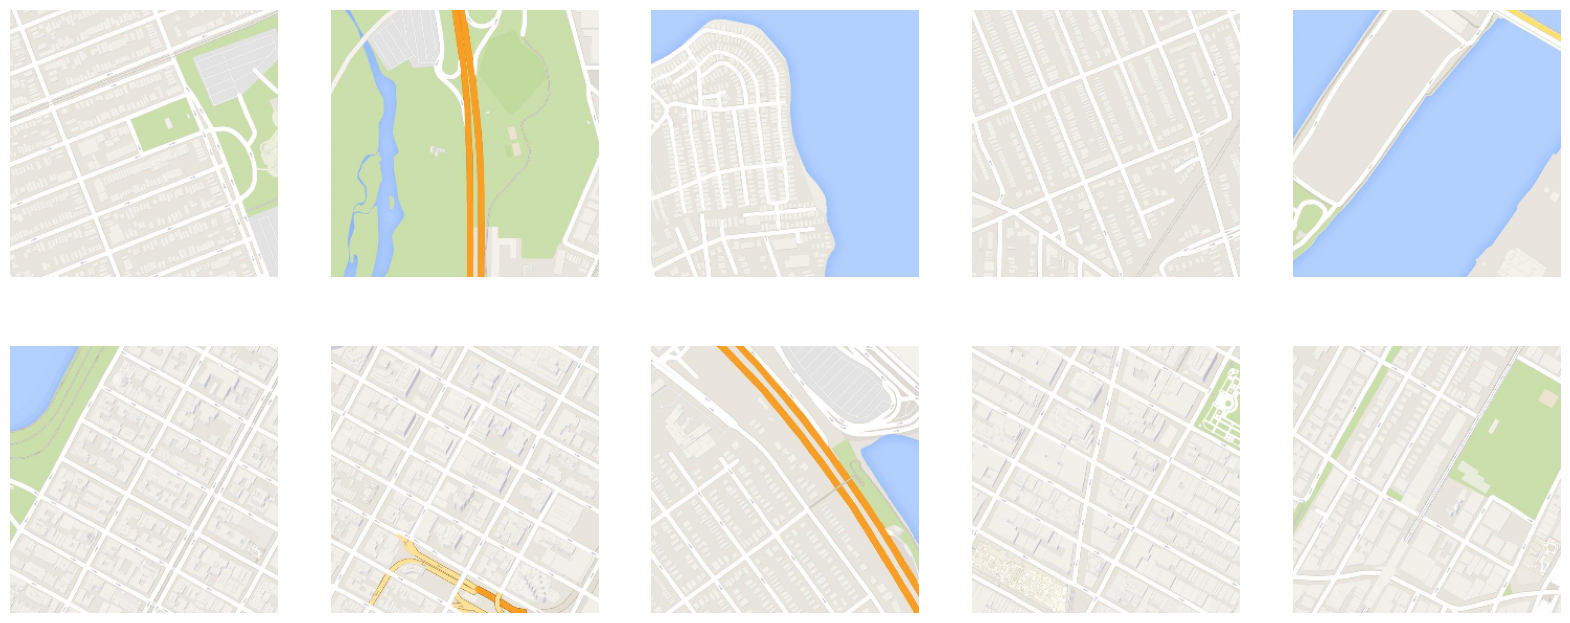

In [51]:
for images, masks in data.take(1):
    sample_images = images
    sample_masks = masks
    break

plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_masks[i])

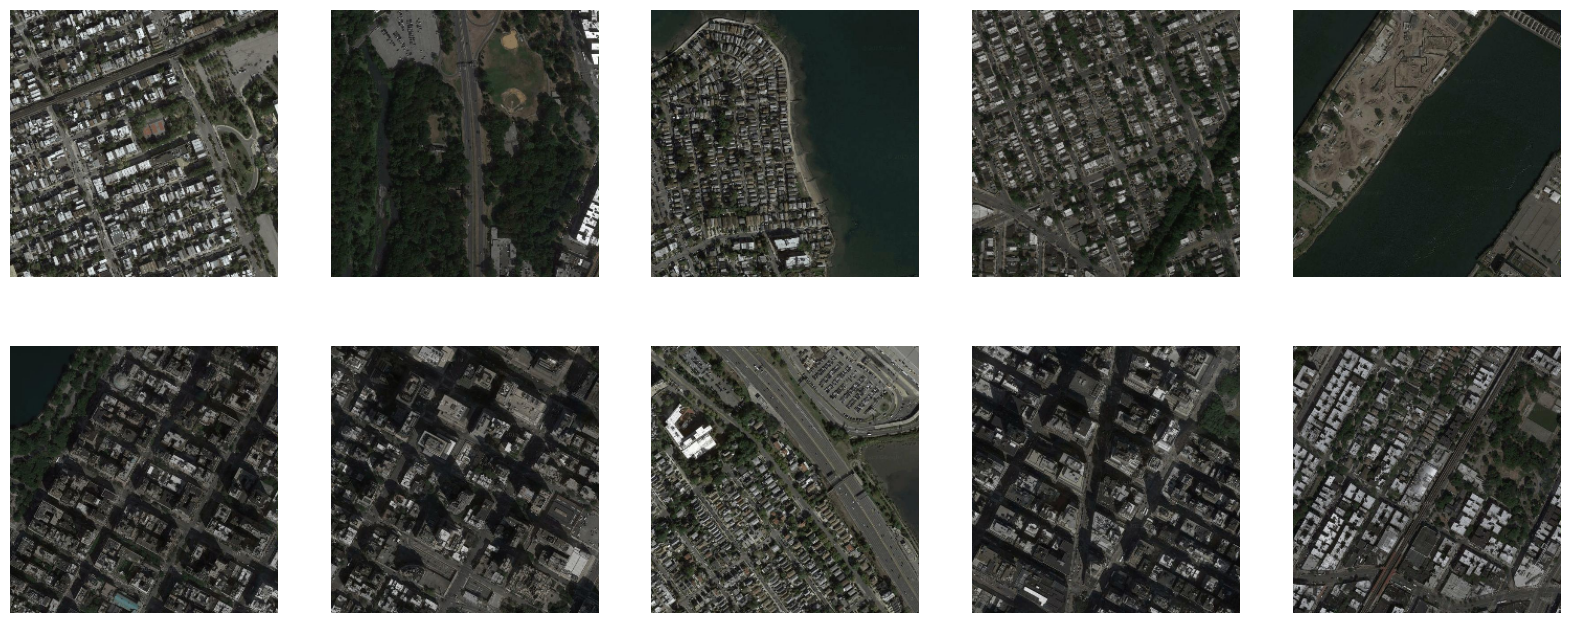

In [52]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_images[i])

# Upsample and Downsample functions

In [53]:
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import Conv2DTranspose

from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

# Model Viz
from tensorflow.keras.utils import plot_model

# Model Losses
from keras.losses import BinaryCrossentropy

def downsample(filters, size, batch_norm=True):
    
  layer = Sequential()
  layer.add(Conv2D(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  if batch_norm:
      layer.add(BatchNormalization())
  layer.add(LeakyReLU())
  
  return layer

def upsample(filters, size, dropout=False):
  layer = Sequential()
  layer.add(Conv2DTranspose(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  layer.add(BatchNormalization())
  if dropout:
      layer.add(Dropout(0.5))
  layer.add(ReLU())
  return layer


# Create the Generator
## The generator is a series of upsampling and downsampling ...

In [54]:
def Generator1():

  inputs = Input(shape=(256,256,3)) 

  downsample_stack = [
    downsample(64, 4, batch_norm=False), # why is batch false here
    downsample(128, 4), 
    downsample(256, 4), 
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4)
    ]

  upsample_stack=[
    upsample(512, 4,dropout=True),
    upsample(512, 4,dropout=True),
    upsample(512, 4,dropout=True), # why is dropout true here
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4),
    ]
  
  last = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', kernel_initializer=tf.random_normal_initializer(0.,0.02))

  x = inputs
  skips = []
  for down in downsample_stack: 
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])
  for up, skip, in zip(upsample_stack, skips):
    x = up(x)
    x = concatenate([x, skip])
  
  x = last(x)
  return Model(inputs=inputs, outputs=x)

In [56]:
generator1 = Generator1()
generator1.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_48       │ (None, 128, 128,  │      3,072 │ input_layer_34[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 64, 64,    │    131,584 │ sequential_48[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 32, 32,    │    525,312 │ sequential_49[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 16, 16,    │  2,099,200 │ sequential_50[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 8, 8, 512) │  4,196,352 │ sequential_51[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 4, 4, 512) │  4,196,352 │ sequential_52[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_54       │ (None, 2, 2, 512) │  4,196,352 │ sequential_53[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_55       │ (None, 1, 1, 512) │  4,196,352 │ sequential_54[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_56       │ (None, 2, 2, 512) │  4,196,352 │ sequential_55[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 2, 2,      │          0 │ sequential_56[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_54[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_57       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 4, 4,      │          0 │ sequential_57[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_53[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_58       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_15[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 8, 8,      │          0 │ sequential_58[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_52[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_59       │ (None, 16, 16,    │  8,390,656 │ concatenate_16[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 16, 16,    │          0 │ sequential_59[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [59]:
class Generator:
  def __init__(self):
    inputs = Input(shape=(256, 256, 3))
    downsample_stack = [
      downsample(64, 4, batch_norm=False), # why is batch false here
      downsample(128, 4), 
      downsample(256, 4), 
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4)]
    
    upsample_stack=[
      upsample(512, 4,dropout=True),
      upsample(512, 4,dropout=True),
      upsample(512, 4,dropout=True), # why is dropout true here
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
      ]
  
    last = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', kernel_initializer=tf.random_normal_initializer(0.,0.02))

    x = inputs
    skips = []
    for down in downsample_stack: 
      x = down(x)
      skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip, in zip(upsample_stack, skips):
      x = up(x)
      x = concatenate([x, skip])
    
    x = last(x)
    self.model = Model(inputs=inputs, outputs=x)

In [60]:
generator = Generator().model
generator.summary()

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_82      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_93       │ (None, 128, 128,  │      3,072 │ input_layer_82[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_94       │ (None, 64, 64,    │    131,584 │ sequential_93[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_95       │ (None, 32, 32,    │    525,312 │ sequential_94[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_96       │ (None, 16, 16,    │  2,099,200 │ sequential_95[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_97       │ (None, 8, 8, 512) │  4,196,352 │ sequential_96[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_98       │ (None, 4, 4, 512) │  4,196,352 │ sequential_97[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_99       │ (None, 2, 2, 512) │  4,196,352 │ sequential_98[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_100      │ (None, 1, 1, 512) │  4,196,352 │ sequential_99[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_101      │ (None, 2, 2, 512) │  4,196,352 │ sequential_100[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 2, 2,      │          0 │ sequential_101[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_99[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_102      │ (None, 4, 4, 512) │  8,390,656 │ concatenate_35[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 4, 4,      │          0 │ sequential_102[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_98[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_103      │ (None, 8, 8, 512) │  8,390,656 │ concatenate_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 8, 8,      │          0 │ sequential_103[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_97[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_104      │ (None, 16, 16,    │  8,390,656 │ concatenate_37[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 16, 16,    │          0 │ sequential_104[0

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

Random testin

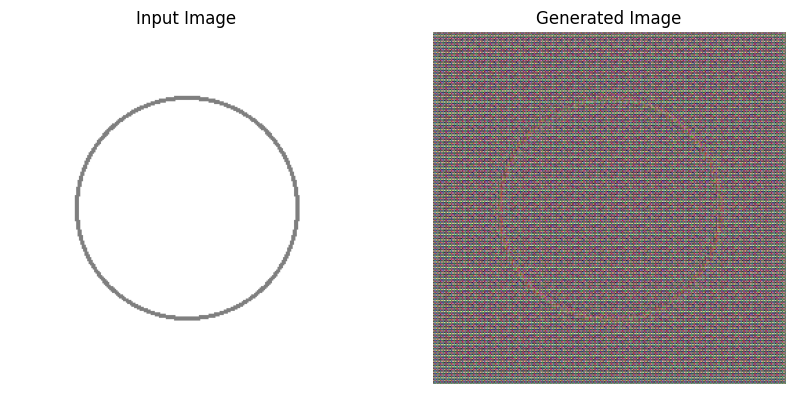

In [ ]:
test_input = np.ones((256, 256, 3), dtype=np.float32)

# Define the circle's parameters
center = (128, 128)
radius = 80
color = (0, 0, 0)
for y in range(256):
    for x in range(256):
        if abs(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) - radius) < 1.5:
            test_input[y, x] = color
test_input = tf.expand_dims(test_input, axis=0)

generated_image = generator(test_input, training=False)

# # Remove the batch dimension and normalize values to [0, 1]
test_input = (test_input[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]
generated_image = (generated_image[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_input.numpy())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image.numpy())
plt.axis("off")

plt.show()

# Create Discriminator


In [79]:
class Discriminator:
  def __init__(self):
    init = tf.random_normal_initializer(0.,0.02)
    input = Input(shape=(256,256,3), name="input_image")
    target = Input(shape=(256,256,3), name="target)image")

    x = concatenate([input, target])
    x = downsample(64, 4, batch_norm=False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    
    x = ZeroPadding2D()(x)
    x = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x)
    
    x = Conv2D(1, 4, kernel_initializer=init)(x)
    self.model = Model(inputs=[input, target], outputs=[x])


In [80]:
discriminator = Discriminator().model
discriminator.summary()

Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target)image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target)image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_108      │ (None, 128, 128,  │      6,144 │ concatenate_42[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_109      │ (None, 64, 64,    │    131,584 │ sequential_108[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_110      │ (None, 32, 32,    │    525,312 │ sequential_109[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_110[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_67      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_67[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

Testing discriminator

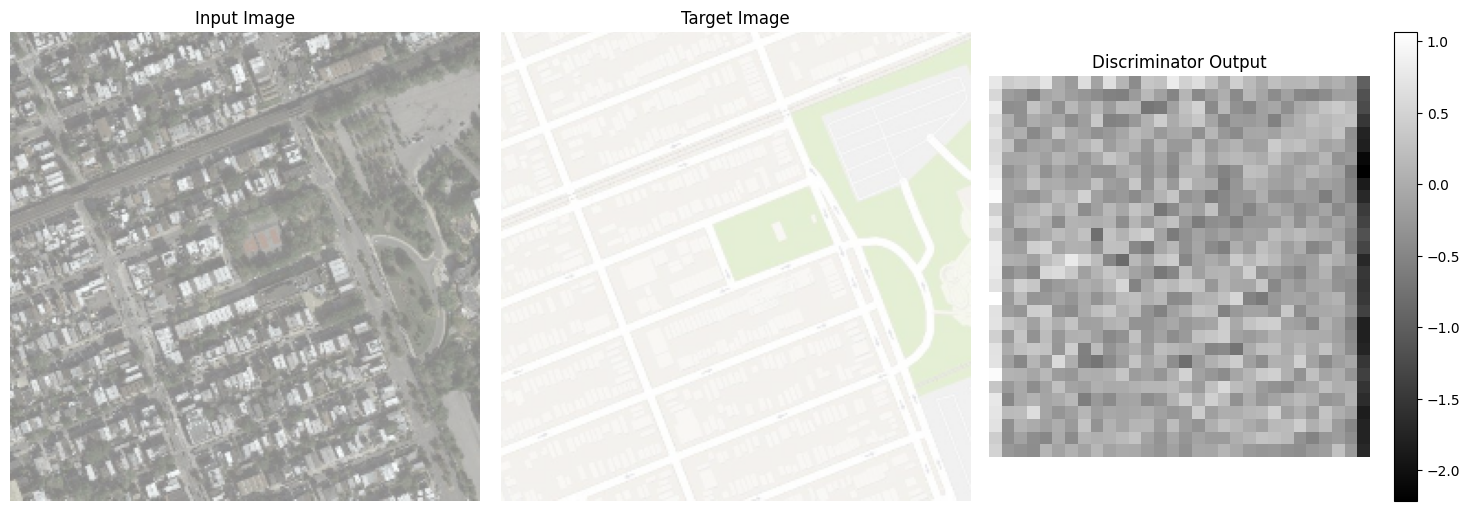

In [84]:
input_test = sample_images[0]
target_test = sample_masks[0]

input_test = tf.expand_dims(input_test, axis=0)
target_test = tf.expand_dims(target_test, axis=0)

discriminator_output = discriminator([input_test, target_test], training=False)[0]


input_test = (input_test[0] + 1) / 2
target_test = (target_test[0] + 1) / 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_test)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Target Image")
plt.imshow(target_test)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Discriminator Output")
plt.imshow(discriminator_output.numpy(), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()


Discriminator is random so output is all over the place